# Projet phylogénétique
Marine Djaffardjy (marine.djaffardjy@u-psud.fr)- Théophile Sanchez - Sarah Cohen Boulakia

------

## Introduction

Au cours de ce projet, vous étudierez trois espèces disparues de félins qui vivaient autrefois sur le continent Américain. Ces trois espèces, le _smilodon_ (tigre à dents de sabre), l'_homotherium_ (_scimitar toothed tigers_) et _M. trumani_ (guépard américain) se sont éteintes il y a environ 13 000 ans, à la fin de la dernière période glaciaire. Des séquences ADN partielles de la protéine cytochrome b de ces espèces ont pu être séquencées et vont vous permettre de retrouver les liens de parentés entre ces espèces et des espèces de félins contemporaines : le chat domestique, le lion, le léopard, le tigre, le puma, le guépard et les chats sauvages africains, chinois et européens. Sont aussi présentes dans le jeu de donnée des séquences issues d'espèces extérieures aux félins.

Afin de reconstruire l'arbre phylogénétique de ces espèces, vous utiliserez une méthode basée sur le calcul des distances évolutives entre les séquences ADN des protéines. Sachez qu'une démarche similaire peut-être appliquée aux séquences d'acides aminés.

Les différentes étapes qui vous permetterons de construire l'arbre sont détaillées dans ce notebook. Vous devrez implémenter les algorithmes en Python et répondre aux questions dans les cellules prévues.

Quelques conseils :
- Utiliser au maximum les fonctions présentes dans les packages de python (sauf si il vous est explicitement demandé de les réimplémenter). Si un problème vous paraît courant, il existe surement déjà une fonction pour le résoudre. Pour ce projet vous serez limité aux packages de base, à Numpy et ETE (seulement pour l'affichage des arbres).
- Si une partie de votre code ne vous semble pas très explicite, ajoutez des commentaires pour l'expliquer. Une personne qui lit votre code doit pouvoir comprendre son fonctionnement facilement.
- N'hésitez pas à chercher dans la documentation et sur internet. Cependant, faites attention au plagiat !

Le projet est à rendre **en binôme** par mail. Vous regrouperez votre notebook et les fichiers nécessaires à son fonctionnement dans une archive portant vos noms et prénoms.

------
## Importation des séquences

Le format FASTA permet de stocker plusieurs séquences (ADN, ARN ou peptidiques) dans un fichier. Les séquences que vous allez étudier ont été regroupées dans le fichier `cat_dna.fasta`.

**Exercice 1 :** Écriver une fonction permettant d'importer un fichier au format fasta et de le stocker dans un dictionnaire. Les clés seront les noms des séquences et les valeurs du dictionnaire seront les séquences d'adn.

In [1]:
dic_data = {}
nom = ''
seq = ''
with open('cat_dna.fasta', 'r') as f:
    for i in f:
        if i == '\n':
            dic_data[nom] = seq
            nom = ''
            seq = ''
        else:
            i = i.split(' ')
            if len(i)>1:
                nom = i[0][1:]
            else:
                seq+=i[0][:-1]
print(dic_data)

{'Sabertooth': 'CTAATTAAAATTATCAACCACTCATTCATTGATTTACCCACCCCATCCAACATTTCAGCATGATGAAACTTCGGCTCCTTATTAGGAGTGTGCTTAATCTTACAAATCCTCACTGGCTTATTTCTAGCCATACATTATACACCAGATACAACAACCGCCTTCTCATCAGTTACCCACATTTGCCGTGATGTTAATTACGGCTGAATTATCCGATATATACACGCCAATGGAGCTTCCATATTCTTCATCTGCCTATATATACATGTAGGTCGAGCATATACTAC', 'Homotherium': 'CTAATTAAAATCATCAACCAATCATTCATTGACTTACCTACCCCCTCCAACATCTCAGCATGATGAAACTTCGGATCCCTACTAGGCATTTGCCTAATTCTTCAAATCCTCACAGGCTTATTCCTAGCCATACACTACACATCAGACACAACAACTGCTTTCTCATCAATCGCCCATATTTGCCGTGACGTAAATTATGGTTGAATTATCCGATATATACACGCCAATGGAGCCTCTATATTCTTCATCTGTCTATACCTACATGTAGCTCGAGAATTTATTAC', 'American': 'CTTATTAAAATCATTAATCACTCATTCATTGATCTACCCACCCCATCCAACATTTCAGCATGATGAAACTTCGGTTCCCTACTAGGGGTCTGCCTAATCCTACAAATCCTAACCGGCCTCTTCCTGGCTATACACTACACATCAGACACAATAACCGCCTTTTCATCAGTTACTCACATCTGTCGTGACGTCAATTACGGCTGAATTATTCGGTATATACACGCCAACGGAGCCTCCATATTCTTTATCTGCCTATACATGCACGTAGGGCGAGAATATATTAC', 'Spotted': 'CTCATTAAAATTATCAACAAATCATTCATTGACCTCCCCACCCCATCCAACATCTCGGCATGGTGAAATTTCGGGTCACTAT

------
## Alignement des séquences

La méthode que vous utiliserez pour calculer l'arbre phylogénétique nécessite de calculer la distance évolutive entre les séquences. Avant de pouvoir les calculer, il faut d'abord aligner les séquences en considérant trois types de mutations :
- les substitutions (un nucléotide est remplacé par un autre)
- les insertions
- les délétions
Par exemple, les séquences "ACTCCTGA" et "ATCTCGTGA" ont plusieurs alignements possibles : 

$A_1$ :
```
-ACTCCTGA
ATCTCGTGA
```

$A_2$ :
```
A-CTCCTGA
ATCTCGTGA
```

$A_3$ :
```
AC-TCCTGA
ATCTCGTGA
```
.

.

.

Le "-" désigne un *gap*, c'est à dire un "trou" dans l'alignement qui a été causé par une insertion ou une déletion. On regroupe ces deux types de mutations sous le terme indel.

Ces alignements correspondent à une multitude d'histoires phylogénétiques différentes. Pour sélectionner le meilleur alignement il faut donc introduire l'hypothèse du maximum de parcimonie qui privilégie l'histoire phylogénétique qui implique le moins d'hypothèses et donc, le moins de changements évolutifs. Par exemple, parmis les trois alignements ci-dessus on preferera l'alignement 2 car il correspond au scénario avec le moins de mutations:
- l'alignement 1 implique au minimum 1 indel et 2 substitutions
- l'alignement 2 implique au minimum 1 indel et 1 substitutions
- l'alignement 3 implique au minimum 1 indel et 2 substitutions

On peut maintenant définir un score d'identité que l'on va augmenter de 1 lorsque qu'il n'y pas eu de mutation et ainsi obtenir la matrice suivante :

|   &nbsp;   | A | C | G | T | - |
|   -   | - | - | - | - | - |
| **A** | 1 | 0 | 0 | 0 | 0 |
| **C** | 0 | 1 | 0 | 0 | 0 |
| **G** | 0 | 0 | 1 | 0 | 0 |
| **T** | 0 | 0 | 0 | 1 | 0 |
| **-** | 0 | 0 | 0 | 0 | 0 |

Cette matrice correspond au modèle d'évolution de l'ADN défini par Jukes et Cantor qui fait l'hypothèse d'un taux de mutation équivalent pour chacun des nucléotides. Cependant, en réalité ces taux ne sont pas les mêmes partout, on sait par exemple que le taux de transition (substitution A$\leftrightarrow$G ou C$\leftrightarrow$T) est différent du taux de transversions (substitution A$\leftrightarrow$T, C$\leftrightarrow$G, C$\leftrightarrow$A ou G$\leftrightarrow$T) et que d'autres facteurs devrait être pris en compte comme la fréquence du nucléotide dans l'ADN. [C'est pour cette raison qu'il existe beaucoup de modèles différents d'écrivant l'évolution de l'ADN.](https://en.wikipedia.org/wiki/Models_of_DNA_evolution) Dans la suite de ce projet nous utiliserons la matrice de similarité $S$ suivante : 

|   &nbsp;   | A  | C  | G  | T  | -  |
|   -   | -  | -  | -  | -  | -  |
| **A** | 10 | -1 | -3 | -4 | -5 |
| **C** | -1 | 7  | -5 | -3 | -5 |
| **G** | -3 | -5 | 9  | 0  | -5 |
| **T** | -4 | -3 | 0  | 8  | -5 |
| **-** | -5 | -5 | -5 | -5 | 0  |

**Exercice 2 :** Écriver la fonction permettant de calculer le score entre deux alignements avec la matrice de similarité précédente puis afficher le score des trois alignements $A_1$, $A_2$ et $A_3$. La classe permettant d'importer une matrice et de calculer le score entre deux lettres vous est déjà fournie, la matrice de similarité est stockée dans le fichier `dna_matrix` :


In [3]:
import numpy as np


class SimilarityMatrix:
    def __init__(self, filename):
        with open(filename) as f:
            self.letters = f.readline().split()
            self.values = np.loadtxt(filename, skiprows=1, usecols=range(1, len(self.letters) + 1))
        
    def score(self, letter1, letter2): # return the similarity score between letter1 and letter2
        return self.values[self.letters.index(letter1)][self.letters.index(letter2)]
    
# Example
similarity_matrix = SimilarityMatrix('dna_matrix')
print('Score between G and C:', similarity_matrix.score('G', 'C'))
print('Score between A and a gap:', similarity_matrix.score('-', 'A'))

Score between G and C: -5.0
Score between A and a gap: -5.0


In [4]:
# À remplir
def score_alignements(a1, a2, similarity_matrix):
    aux = 0
    for i, j in zip(a1, a2):
        aux+=similarity_matrix.score(i, j)
    return aux
        
print(score_alignements('-ACTCCTGA', 'ATCTCGTGA', similarity_matrix))
print(score_alignements('A-CTCCTGA', 'ATCTCGTGA', similarity_matrix))
print(score_alignements('AC-TCCTGA', 'ATCTCGTGA', similarity_matrix))

35.0
49.0
39.0


------
### Algorithme de Needleman-Wunsch

Maintenant que vous avez vu ce qu'est une matrice de similarité et comment calculer le score de similarité d'un alignement, vous allez devoir implémenter un algorithme permettant de trouver le meilleur alignement global entre deux séquences. Avec deux séquences à aligner de taille $n$ et $m$, la première étape consiste à initialiser deux matrices de taille $(n+1) \times (m+1)$. La première est la matrice de score $M$ et la seconde sera la matrice de *traceback* $T$. 

Par exemple, avec la matrice $S$ et les séquences $A =$ "ACTCCTGA" et $B =$ "ATCTCGTGA", on initialise $M$ comme si l'on ajoutait des *gaps* partout :

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | 0 |-5 |-10|-15|-20|-25|-30|-35|-40|-45|
| **A** |-5 | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** |-10| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** |-15| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** |-20| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** |-25| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** |-30| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **G** |-45| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **A** |-40| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; ||

Puis on initialise $T$ :

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | o | l | l | l | l | l | l | l | l | l |
| **A** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **G** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **A** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; ||


Il faut ensuite remplir la matrice $M$ en suivant la formule $M_{ij} = \max(M_{i-1j-1} + s(A_i, B_j), M_{ij-1} + s(A_i, gap), M_{i-1j} + s(B_j,gap) )$ avec $i \in {2, \dots, n+1}$, $j \in {2, \dots, m+1}$ et la fonction $s$ qui calcule le score de similarité entre deux nucléotides. Pour chaque case de $T$ on remplie par :
- 'd' (*diagonal*) si $M_{ij}$ a été calculé en utilisant la diagonale $M_{i-1j-1}$,
- 'l' (*left*) si $M_{ij}$ a été calculé en utilisant la case de gauche $M_{ij-1}$,
- 'u' (*up*) si $M_{ij}$ a été calculé en utilisant la case du haut $M_{i-1j}$.

On obtient alors les matrices suivantes $M$ et $T$ : 

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** |  0| -5|-10|-15|-20|-25|-30|-35|-40|-45|
| **A** | -5| 10|  5|  0| -5|-10|-15|-20|-25|-30|
| **C** |-10|  5|  7| 12|  7|  2| -3| -8|-13|-18|
| **T** |-15|  0| 13|  8| 20| 15| 10|  5|  0| -5|
| **C** |-20| -5|  8| 20| 15| 27| 22| 17| 12|  7|
| **C** |-25|-10|  3| 15| 17| 22| 22| 19| 14| 11|
| **T** |-30|-15| -2| 10| 23| 18| 22| 30| 25| 20|
| **G** |-35|-20| -7|  5| 18| 18| 27| 25| 39| 34|
| **A** |-40|-25|-12|  0| 13| 17| 22| 23| 34| 49|

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | o | l | l | l | l | l | l | l | l | l |
| **A** | u | d | l | l | l | l | l | l | l | d |
| **C** | u | u | d | d | l | d | l | l | l | l |
| **T** | u | u | d | l | d | l | l | d | l | l |
| **C** | u | u | u | d | l | d | l | l | l | l |
| **C** | u | u | u | d | d | d | d | d | l | d |
| **T** | u | u | d | u | d | l | d | d | l | l |
| **G** | u | u | u | u | u | d | d | u | d | l |
| **A** | u | d | u | u | u | d | u | d | u | d |

Il suffit maintenant de regarder le dernier élément $M_{nm} = 49$ pour avoir le score de l'alignement. Pour avoir l'alignement lui-même, il faut partir de $T_{nm}$ et remonter la "trace" jusqu'à arriver au 'o'. Un 'd' correspond à un *match* entre les deux séquences, 'l' à un *gap* dans la séquence $A$ et 'u' à un *gap* dans la séquence $B$. En revenant à l'exemple précédent on obtient la trace suivante :

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | o | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **A** | &nbsp; | d | l | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; | &nbsp; |
| **T** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; |
| **G** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; |
| **A** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d |

Elle correspond à l'alignement :
```
A-CTCCTGA
ATCTCGTGA
```

**Exercice 3 :** Implémenter l'algorithme de Needlman et Wunsch. Il prendra en paramètre deux séquences et une matrice de similarité et retournera leur alignement. Tester le avec les séquences "ACTCCTGA" et "ATCTCGTGA".

In [5]:
# À remplir
def create_matrix(seq1, seq2):
    len1 = len(seq1)
    len2 = len(seq2)
    M = np.zeros((len1+1, len2+1))
    T = np.empty([len1+1, len2+1], dtype=str)
    l1 = [-i for i in range(0, (len2+1)*5, 5)]
    l2 = ["l" for i in range(len2+1)] 
    l3 = ["u" for i in range(len2+1)]
    M[0:,0] = l1[:-1]
    M[0,] = l1
    T[0:,0] = l3[:-1]
    T[0,] = l2
    T[0][0]='o'
    return M, T

def fill_matrix(seq1, seq2, similarity_matrix, M, T):
    s1 = [i for i in seq1]
    s2 = [i for i in seq2]
    s1.insert(0, '-')
    s2.insert(0, '-')
    aux = {}
    for i in range(1,len(M)):
        for j in range(1,len(M[i])):
            aux['u'] = M[i-1][j] -5
            aux['l'] = M[i][j-1] -5 
            aux['d'] = M[i-1][j-1] + similarity_matrix.score(s1[i], s2[j])
            final = max(aux, key=aux.get)
            M[i][j] = aux[final]
            T[i][j] = final
            
def traceback(seq1, seq2, T):
    alignement1 = ''
    alignement2 = ''
    i = len(T)-1
    j = len(T[0])-1
    actual = T[i][j]
    
    stop=False
    while not stop:
        if seq1[i-1] == seq2[j-1]:
            alignement1+=seq1[i-1]
            alignement2+=seq1[i-1]
            i-=1
            j-=1
        else:
            if actual == 'l': #case LEFT
                alignement1+='-'
                alignement2+=seq2[j-1]
                j-=1
            elif actual == 'u': #case UP
                alignement1+=seq1[i-1]
                alignement2+='-'
                i-=1
            else: #actual == 'd'CASE DIAGONAL
                alignement1+=seq1[i-1]
                alignement2+=seq2[j-1]
                i-=1
                j-=1
        actual = T[i][j]
        if actual == 'o':
            stop = True
            alignement1 = alignement1[::-1]
            alignement2 = alignement2[::-1]
            
    return alignement1, alignement2

def needlemandwunsch(seq1, seq2, similarity_matrix):
    
    M, T = create_matrix(seq1, seq2)
    
    fill_matrix(seq1, seq2, similarity_matrix, M, T)
    
    alignement1, alignement2 = traceback(seq1, seq2, T)    
    
    return alignement1, alignement2

seq1 = "ACTCCTGA" 
seq2 = "ATCTCGTGA"
a1, a2 = needlemandwunsch(seq1, seq2, similarity_matrix)
print(a1, a2)

A-CTCCTGA ATCTCGTGA


----
## Matrice de distance

Dans le cas de séquences très proches, on estime que la distance évolutive réelle entre les séquences est proche de la p-distance qui est simplement le nombre de substitution dans l'alignement sur le nombre total de nucléotide. Pour simplifier, on ignore les positions alignées à des gaps. On applique ensuite la correction de Jukes-Cantor afin de prendre en compte le phénomène de saturation (un même site peut muter plusieurs fois au cours du temps). Sa formule est $-(\frac{3}{4})\ln(1-(\frac{4}{3})\times \textit{p-distance})$.

**Exercice 4 :** Implémenter la fonction retournant la matrice de distance à partir d'un dictionnaire de séquences. 

In [8]:
# À remplir
def calculer_distance(seq1, seq2):
    compt=0
    for i,j in zip(seq1, seq2):
        if not (i == '-' or j =='-'):
            if i != j:
                compt+=1
    compt = compt/len(seq2)
    
    return round(-(3.0/4.0)*np.log(1-(4.0/3.0)*compt), 10)
print(calculer_distance(a1, a2))
#well compt must be less than 3/4 for this to work correctly, cause the log has to take a positive value

0.1202569876


In [9]:
#hay q calcular las distancias entre todas las parejas del documento cat_dna.fasta (el diccionario es el del ej1)

In [11]:
from sympy import Matrix
matrix2 = np.zeros([len(dic_data), len(dic_data)], dtype = float)
matrix2[0][0] = 0
names = list(dic_data.keys())
names.insert(0, '')

for i in range(1,len(dic_data)):
    for j in range(1,len(dic_data)):
        print(names[i], names[j])
        val = round(calculer_distance(dic_data[names[i]], dic_data[names[j]]), 5)
        if val < 0.01:
            val = 0.00001
        matrix2[i][j] = val
        #print(matrix2[i][j],",",val)

#init_printing()
#display(matrix)
display(Matrix(matrix2))

Sabertooth Sabertooth
Sabertooth Homotherium
Sabertooth American
Sabertooth Spotted
Sabertooth Striped
Sabertooth Chinese
Sabertooth African
Sabertooth Felis
Sabertooth Wild
Sabertooth Cheetah
Sabertooth Puma
Sabertooth Tiger
Sabertooth Lion
Sabertooth Leopard
Sabertooth Dog
Sabertooth Wolf
Sabertooth Black
Homotherium Sabertooth
Homotherium Homotherium
Homotherium American
Homotherium Spotted
Homotherium Striped
Homotherium Chinese
Homotherium African
Homotherium Felis
Homotherium Wild
Homotherium Cheetah
Homotherium Puma
Homotherium Tiger
Homotherium Lion
Homotherium Leopard
Homotherium Dog
Homotherium Wolf
Homotherium Black
American Sabertooth
American Homotherium
American American
American Spotted
American Striped
American Chinese
American African
American Felis
American Wild
American Cheetah
American Puma
American Tiger
American Lion
American Leopard
American Dog
American Wolf
American Black
Spotted Sabertooth
Spotted Homotherium
Spotted American
Spotted Spotted
Spotted Striped
Sp

Matrix([
[0.0,     0.0,     0.0,     0.0,     0.0,     0.0,     0.0,     0.0,     0.0,     0.0,     0.0,     0.0,     0.0,     0.0,     0.0,     0.0,     0.0,     0.0],
[0.0,  1.0e-5, 0.16035, 0.16035, 0.14738, 0.19151, 0.13463, 0.16035, 0.16472, 0.16472, 0.17355, 0.18698, 0.13886, 0.15168, 0.14311, 0.24325, 0.24325, 0.24325],
[0.0, 0.16035,  1.0e-5, 0.18698, 0.18247, 0.21459, 0.18698, 0.21929, 0.20527, 0.21459, 0.20992, 0.21459, 0.20527, 0.22878, 0.20992, 0.25801, 0.25801, 0.27306],
[0.0, 0.16035, 0.18698,  1.0e-5, 0.18698,   0.178, 0.10166, 0.10977, 0.13043,  0.1221,  0.0857, 0.06238, 0.12625, 0.16035, 0.16035, 0.25306, 0.25306, 0.24325],
[0.0, 0.14738, 0.18247, 0.18698,  1.0e-5, 0.13463, 0.14738, 0.18698, 0.18247,   0.178, 0.19151, 0.21459,   0.178, 0.20066, 0.20066, 0.25306, 0.25306, 0.25306],
[0.0, 0.19151, 0.21459,   0.178, 0.13463,  1.0e-5, 0.16912,   0.178, 0.19151, 0.18698, 0.16472, 0.21929, 0.20992, 0.21459, 0.21459, 0.26299, 0.26299, 0.25306],
[0.0, 0.13463, 0.18698, 0.10166

------
## Construction d'un arbre avec UPGMA

Grâce aux mesures de distances entre les séquences, on peut maintenant de construire l'arbre phylogénétique des globines. Vous allez devoir pour cela implémenter l'algorithme UPGMA (*unweighted pair group method with arithmetic mean*) qui, malgré son nom compliqué, est l'une des méthodes les plus simples pour la construction d'arbre.

### Le format Newick

Le format Newick est l'un des formats utilisé en phylogénie pour représenter un arbre sous la forme d'une chaine de caractère. Le principe est simple, les groupes ayant la même racine sont écrit entre parenthèses et séparés par des virgules. Un groupe peut être soit une feuille de l'arbre (dans notre cas une séquence), soit un autre groupe. La longueur de la branche de chaque groupe est écrite après un double point et l'arbre est terminé par un point virgule. Pour afficher l'arbre on peut utiliser les fonction du package ETE : 

In [12]:
!pip install ete3

Defaulting to user installation because normal site-packages is not writeable


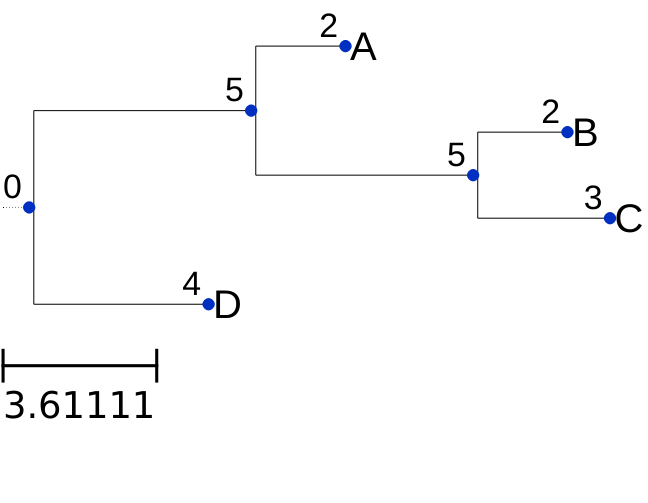

In [13]:
from ete3 import Tree, TreeStyle

newick_tree = '((A:2,(B:2,C:3):5):5,D:4);'
t = Tree(newick_tree)
ts = TreeStyle()
ts.show_branch_length = True
t.render('%%inline', w=183, units='mm', tree_style=ts)

**Exercice 5 :** Reécriver l'arbre suivant au format Newick puis afficher-le. Les nombres correspondent aux longueurs des branches :
![](tree.png)

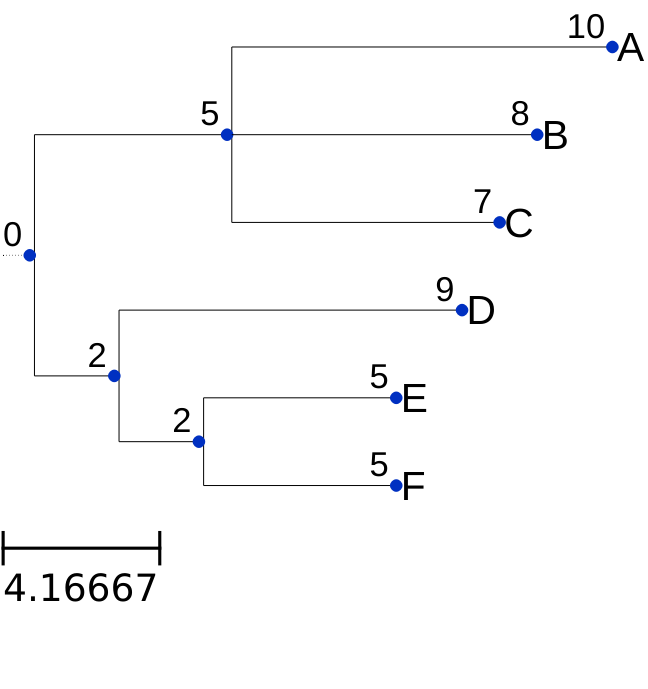

In [14]:
# À remplir
newick_tree_ex5 = '((A:10, B:8, C:7):5, (D:9,(E:5,F:5):2):2);'
t = Tree(newick_tree_ex5)
ts = TreeStyle()
ts.show_branch_length = True
t.render('%%inline', w=183, units='mm', tree_style=ts)

**Exercice 6 :** Expliquer la relation de parenté entre $A$, $B$ et $C$ ? Qu'elles sont les hypothèses qui pourraient expliquer ce type d'embranchement dans un arbre ? Donner une réponse détaillée.

Réponse : 

### UPGMA

L'algorithme UPGMA se base sur la matrice de distance entre les séquences. À chaque itération, les séquences avec la distance la plus faible sont regroupées puis une nouvelle matrice de distance est calculée avec le nouveau groupe. Cette étape est répétée jusqu'à n'avoir plus qu'un seul groupe. Par exemple, avec la matrice de distance entre les séquences $A$, $B$, $C$ et $D$ suivante :

|   &nbsp;   | A | B | C | D |
|   -   | - | - | - | - |
| **A** | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **B** | 4 | &nbsp; | &nbsp; | &nbsp; |
| **C** | 8 | 8 | &nbsp; | &nbsp; |
| **D** | 2 | 4 | 8 | &nbsp; |

Les séquences $A$ et $D$ sont les plus proches ($distance(A,D)=2$). On les regroupe et on met à jour la matrice :

|   &nbsp;   | (A, D) | B | C |
|   -   | - | - | - |
| **(A, D)** | &nbsp; | &nbsp; | &nbsp; |
| **B** | 4 | &nbsp; | &nbsp; |
| **C** | 8 | 8 | &nbsp; | &nbsp; |

On regroupe maintenant $(A,D)$ et $B$ ($distance((A,D),B) = 4$) :

|   &nbsp;   | ((A, D), B) | C |
|   -   | - | - |
| **((A, D), B)** | &nbsp; | &nbsp; |
| **C** | 8 | &nbsp; |

Important : les nouvelles distances sont calculées en moyennant les distances entre les membres du nouveau groupe et des groupes non modifiés pondéré par le nombre d'UTOs dans chaque groupe. Avec $i$ et $j$ les deux membres du groupe nouvellement formé et k les groupes restant : $d_{ij,k} = \frac{n_id_{ik}}{n_i + n_j}+ \frac{n_jd_{jk}}{n_i + n_j}$. Par exemple avec la distance entre $((A, D), B)$ et $C$:

$distance(((A, D), B), C) = (distance((A, D), C)*2 + distance(B, C)) \mathbin{/} 3 = (8*2 + 8) \mathbin{/} 3 = 8 $.

L'arbre final écrit dans le format Newick est : $((A, D), B), C);$ 

Et avec les distances : $((A:1, D:1):1, B:2):2, C:4);$ 

**Exercice 7 :** Implémenter une version d'UPGMA qui calcule l'arbre au format Newick **avec les distances** puis appliquer votre algorithme aux données. 

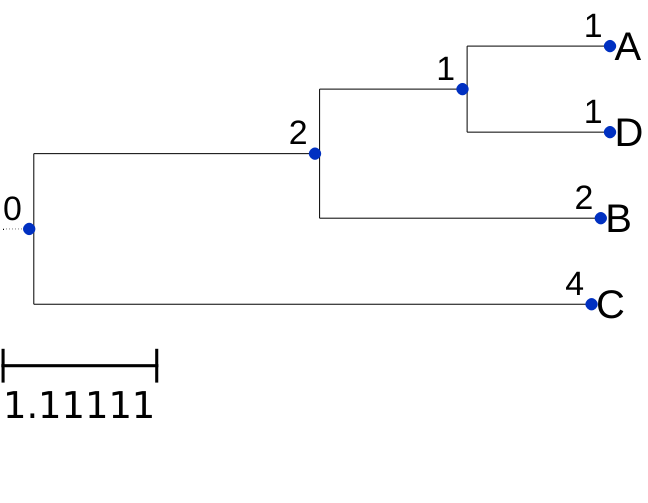

In [15]:
newick_tree = '(((A:1, D:1):1, B:2):2, C:4);'
t = Tree(newick_tree)
ts = TreeStyle()
ts.show_branch_length = True
t.render('%%inline', w=183, units='mm', tree_style=ts)

In [16]:
#m = ((('A', 'B'), 'C'), ('D', ('A','E')))
#'(((A:1, D:1):1, B:2):2, C:4);'
#{((('A', 'D'), 'B'), 'C'): 8.0}
def len_tup(tup):
    if len(tup)==1:
        return 1
    else:        
        return len_tup(tup[0])+len_tup(tup[1])

def dist(key):
    return (counti * d)/len(m)

In [22]:
import copy
d = {('A', 'B'): 4, ('A', 'C'): 8, ('A', 'D'): 2, ('B', 'C'): 8, ('B', 'D'): 4, ('C', 'D'): 8}
indices = ['A', 'B', 'C', 'D']


def upgma(d, indices):
    final_tree = ''
    d2 = copy.deepcopy(d)
    branch_length = dict(zip(indices, [0 for i in range(len(indices))]))
    
    while len(d) > 1:
        #Find closest pair in distance matrix d
        m = min(d, key=d.get)
        temp = []
        counti = len_tup(m[0])
        countj = len_tup(m[1])
        #Add new node in tree
        to_remove = []
        
        for i in indices:
            new_dist = 0
            calculated = False
            for j in indices:
                if i not in m and j in m:
                    calculated = True
                    new = (m,i)
                    try:
                        new_dist = new_dist + (len_tup(j) * d[(j,i)])/len_tup(m)
                        to_remove.append((j,i))
                    except:
                        new_dist = new_dist + (len_tup(i) * d[(i,j)])/len_tup(m)
                        to_remove.append((i,j))
                    
            #calculate the new distances
            if calculated:
                d[new]=new_dist
                d2[new]=new_dist
                #length of the branch
            if m not in temp:
                temp.insert(0,m)

        indices += temp
        branch_length[m] = d[m]/2
        branch_length[m[0]]=d[m]/2-branch_length[m[0]]
        branch_length[m[1]]=d[m]/2-branch_length[m[1]]
        if len_tup(m)==2:
            final_tree='('+final_tree+str(m[0])+':'+str(branch_length[m[0]])+','+str(m[1])+':'+str(branch_length[m[1]])+')'
        else:
            final_tree='('+final_tree+':'+str(branch_length[m[0]])+','+str(m[1])+':'+str(branch_length[m[1]])+')'
        for key in to_remove:
            del d[key]
        del d[m]
        if len(d)==1:
            #print("len=1",d)
            a = list(d.keys())
            branch_length[a[0]] = d[a[0]]/2
            branch_length[a[0][1]]=d[a[0]]/2-branch_length[a[0][1]]
            if len_tup(a[0])==2:
                final_tree='('+final_tree+str(a[0][0])+':'+str(branch_length[a[0][0]])+','+str(a[0][1])+':'+str(branch_length[a[0][1]])+')'
            else:
                final_tree='('+final_tree+':'+str(branch_length[a[0][0]])+','+str(a[0][1])+':'+str(branch_length[a[0][1]])+')'
                
        for ind in m:
            indices.remove(ind)   
    print('branch_length',branch_length)
    print(final_tree+';')
    
    return final_tree+';'

tree = upgma(d, indices)
#'(((A:1, D:1):1, B:2):2, C:4);'YAS KURWA!!!


branch_length {'A': 1.0, 'B': 2.0, 'C': 4.0, 'D': 1.0, ('A', 'D'): 1.0, (('A', 'D'), 'B'): 2.0, ((('A', 'D'), 'B'), 'C'): 4.0}
(((A:1.0,D:1.0):1.0,B:2.0):2.0,C:4.0);


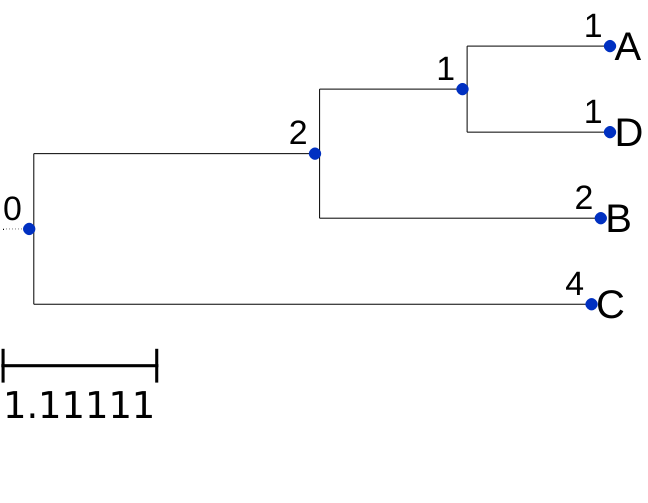

In [23]:
t = Tree(tree)
ts = TreeStyle()
ts.show_branch_length = True
t.render('%%inline', w=183, units='mm', tree_style=ts)

In [24]:
def calculate_permutations(l):
    final = []
    for i in l:
        for j in l:
            if i!=j:
                tupl = (i,j)
                tupl2 = (j,i)
                if tupl not in final and tupl2 not in final:
                    final.append(tupl)
    return final

In [25]:
names = list(dic_data.keys())
final = []

final = calculate_permutations(names)

dic_distances = {}
for i in final:
    dic_distances[i] = round(calculer_distance(i[0], i[1]), 5)

print(dic_distances)
print(len(dic_distances))

{('Sabertooth', 'Homotherium'): nan, ('Sabertooth', 'American'): nan, ('Sabertooth', 'Spotted'): nan, ('Sabertooth', 'Striped'): nan, ('Sabertooth', 'Chinese'): nan, ('Sabertooth', 'African'): nan, ('Sabertooth', 'Felis'): nan, ('Sabertooth', 'Wild'): nan, ('Sabertooth', 'Cheetah'): nan, ('Sabertooth', 'Puma'): nan, ('Sabertooth', 'Tiger'): 1.20708, ('Sabertooth', 'Lion'): nan, ('Sabertooth', 'Leopard'): nan, ('Sabertooth', 'Dog'): nan, ('Sabertooth', 'Wolf'): nan, ('Sabertooth', 'Black'): nan, ('Sabertooth', 'Brown'): nan, ('Homotherium', 'American'): nan, ('Homotherium', 'Spotted'): nan, ('Homotherium', 'Striped'): nan, ('Homotherium', 'Chinese'): nan, ('Homotherium', 'African'): nan, ('Homotherium', 'Felis'): nan, ('Homotherium', 'Wild'): nan, ('Homotherium', 'Cheetah'): nan, ('Homotherium', 'Puma'): inf, ('Homotherium', 'Tiger'): nan, ('Homotherium', 'Lion'): nan, ('Homotherium', 'Leopard'): nan, ('Homotherium', 'Dog'): 1.64792, ('Homotherium', 'Wolf'): inf, ('Homotherium', 'Black'

<ipython-input-8-ede97bf83896>:10: RuntimeWarning: invalid value encountered in log
  return round(-(3.0/4.0)*np.log(1-(4.0/3.0)*compt), 10)
<ipython-input-8-ede97bf83896>:10: RuntimeWarning: divide by zero encountered in log
  return round(-(3.0/4.0)*np.log(1-(4.0/3.0)*compt), 10)


In [26]:
tree_upgma = upgma(copy.deepcopy(dic_distances), names)
print(tree_upgma)

branch_length {'Sabertooth': nan, 'Homotherium': nan, 'American': nan, 'Spotted': nan, 'Striped': nan, 'Chinese': nan, 'African': nan, 'Felis': nan, 'Wild': 0.41198, 'Cheetah': nan, 'Puma': nan, 'Tiger': nan, 'Lion': 0.17984, 'Leopard': 0.17984, 'Dog': 0.60354, 'Wolf': 0.41198, 'Black': 0.60354, 'Brown': nan, ('Sabertooth', 'Homotherium'): nan, ('American', 'Spotted'): nan, ('Striped', 'Chinese'): nan, ('African', 'Felis'): nan, ('Lion', 'Leopard'): nan, ('Wild', 'Wolf'): nan, ('Cheetah', 'Puma'): nan, ('Dog', 'Black'): nan, ('Tiger', 'Brown'): nan, (('American', 'Spotted'), ('Sabertooth', 'Homotherium')): nan, (('African', 'Felis'), ('Striped', 'Chinese')): nan, (('Wild', 'Wolf'), ('Lion', 'Leopard')): nan, (('Dog', 'Black'), ('Cheetah', 'Puma')): nan, ((('American', 'Spotted'), ('Sabertooth', 'Homotherium')), ('Tiger', 'Brown')): nan, ((('Wild', 'Wolf'), ('Lion', 'Leopard')), (('African', 'Felis'), ('Striped', 'Chinese'))): nan, (((('American', 'Spotted'), ('Sabertooth', 'Homotherium

**Exercice 8 :** Quelles sont les hypothèses faites par UPGMA ? Semblent-elles respectées dans le cas présent ?

Réponse : 

----
## Enracinement de l'arbre

Après avoir utilisé UPGMA pour réaliser votre arbre, l'enracinement s'est normalement fait au poids moyen. 

**Exercice 9 :** Quelle autre méthode est-il possible d'utiliser pour enraciner un arbre ? Pouvez-vous l'utilisez ici ? Si oui, afficher le nouvel arbre.

Réponse : Contrairement à l'enracinement moyen pondéré que nous avons effectué avec l'algorithme upgma, qui nous donne un arbre phylogénétique dans lequel toutes les séquences évoluent à la même vitesse, il y a la possibilité d'effectuer l'enracinement avec un groupe extérieur. Ce dernier nous permet de définir la racine par le nœud qui rejoint le groupe extérieur avec les séquences étudiées.

In [ ]:
# À remplir

----
## Neighbor-joining

Le neighbor-joining est un autre algorithme permettant de calculer un arbre phylogénique à partir d'une matrice de distance. Il a l'avantage de faire moins d'hypothèse qu'UPGMA sur les données (elles ne sont plus forcément ultramétrique) et il donne donc de meilleurs arbres dans presque tout les cas. Vous trouverez un example d'application de cet algorithme [ici](http://www.evolution-textbook.org/content/free/tables/Ch_27/T11_EVOW_Ch27.pdf).

**Exercice 10 :** Implémenter l'algorithme du neighbor-joining, appliquer-le aux données puis enraciner l'arbre.

In [ ]:
# À remplir
# https://ressources.unisciel.fr/intro_biologie_evolution/co/grain5_3_2_2.html aqui hay un ejemplo

In [ ]:
def traceback_neighbor(dic_aux):
    tree = ''
    compt = 0
    compt_final = 1
    for i in dic_aux:
        if compt_final == len(dic_aux):
                tree = '('+tree + ','+ str(i)+':'+str(dic_aux[i]) +');'
                return(tree)
        if compt_final == len(dic_aux)-1:
                tree = tree  + str(i) +':'+str(dic_aux[i])
        elif compt_final == 1:
            tree = '('+i+':'+str(dic_aux[i])+','
        elif compt_final == 2:
            tree += i+':'+str(dic_aux[i])+')'
        else:
            if compt == 0:
                tree += ':'+str(dic_aux[i])+ ','
            else:
                 tree = '('+ tree + str(i)+':'+str(dic_aux[i]) +')'
        compt +=1
        compt_final +=1
        if compt%2 == 0:
            compt = 0
    

In [ ]:
def neighbor_joining(d, indices):
    
    #compt_union = 0
    dic_aux = {}
    
    while len(indices) > 1:
        print(d)
        lastelement = False
        to_remove = []
        
        #calculate S for each node - Step 1
        s = {}
        for i in indices:
            suma = 0
            for j in indices:
                if i!=j:
                    try:
                        suma += d[(i,j)]
                    except:
                        suma+= d[(j,i)]
            try:
                suma/=len(indices)-2
            except:
                lastelement = True
            s[i] = suma
        
        if not lastelement:
            #calculate M for each pair of nodes - Step 2
            pairs = calculate_permutations(indices)

            m = {}
            for i in pairs:
                val = 0
                try:
                    val += d[(i)]
                except:
                    val += d[(i[1], i[0])]
                val -= (s[i[0]] + s[i[1]])
                m[i] = val

            val_min = min(m, key=m.get)

            #compt_union += 1
            #union = 'u'+str(compt_union)

            u = {}
            try:
                u[(val_min[0], val_min)] = (d[val_min] +(s[val_min[0]] - s[val_min[1]]))/2
                u[(val_min[1], val_min)] = (d[val_min] +(s[val_min[1]] - s[val_min[0]]))/2
                
            except:
                u[(val_min[0], val_min)] = (d[(val_min[1], val_min[0])] +(s[val_min[0]] - s[val_min[1]]))/2
                u[(val_min[1], val_min)] = (d[(val_min[1], val_min[0])] +(s[val_min[1]] - s[val_min[0]]))/2
            dic_aux[val_min[0]] = u[(val_min[0], val_min)]
            dic_aux[val_min[1]] = u[(val_min[1], val_min)]
            
            

            for i in indices:
                new_dist = 0
                calculated = False
                for j in indices:
                    if i not in val_min and j in val_min:
                        new = (val_min, i)
                        try:
                            new_dist += d[(i,j)]
                            to_remove.append((i,j))

                        except:
                            new_dist += d[(j,i)]
                            to_remove.append((j,i))
                        calculated = True
                if calculated:
                    d[new] = (new_dist - d[val_min])/2
                if val_min not in to_remove:
                    to_remove.insert(0,val_min)
                    
            indices.insert(0,val_min)
            indices.remove(val_min[0])
            indices.remove(val_min[1])

            for key in to_remove:
                del d[key]
        else:
            new = (indices[0][0], indices[0][1], indices[1])
            val = list(d.values())
            dic_aux[indices[1]] = val[0]
            d = { new : val[0]}
            indices = [new]
            
    tree = traceback_neighbor(dic_aux)
            
    return tree

In [ ]:
dic2 = {('A', 'B'): 5, ('A', 'C'): 4, ('A', 'D'): 7, ('A', 'E'): 6, ('A', 'F'): 8, ('B', 'C'): 7, ('B', 'D'): 10, ('B', 'E'): 9, ('B', 'F'): 11, ('C', 'D'): 7, ('C', 'E'): 6, ('C', 'F'): 8, ('D', 'E'): 5, ('D', 'F'): 9, ('E', 'F'): 8, }
indices2 = ['A', 'B', 'C', 'D', 'E', 'F']
tree= neighbor_joining(dic2, indices2)
print(tree)

t = Tree(tree)
ts = TreeStyle()
ts.show_branch_length = True
t.render('%%inline', w=183, units='mm', tree_style=ts)

In [ ]:
tree_neighbor = neighbor_joining(copy.deepcopy(dic_distances), names)

print(len(dic_distances))
print(tree_neighbor)

----
## Bootstrap

Le bootstrap est une méthode permettant de calculer la robustesse des branches d'un arbre. Il sagit de recréer un jeu de données artificiel en tirant n positions dans l'alignement des séquences avec remise, n étant la longueur de l'alignement. On recréer un arbre à partir de ces nouvelles données puis on le compare avec l'arbre obtenu avec les données réelles. Si une branche de l'arbre réelle est présente dans l'arbre artificiel, son bootstrap augmente de 1. On répètera la procédure 100 fois afin d'avoir un score sur 100 pour chaque branche.

**Exercice 11 :** Calculer le bootstrap des branches des arbres obtenus avec UPGMA et neighbor-joining.

In [ ]:
# À remplir

----
## Conclusion

**Exercice 12 :** Quelles sont vos conclusions par rapport à l'arbre phylogénique de _smilodon_, _homotherium_ et _M. trumani_ ? Comparer les deux méthodes. Comment expliquer les caractéristiques morphologiques similaires entre ces trois espèces ? Une réponse détaillée est attendue.

Réponse :